# Image Captioning using the Flickr Kaggle Dataset

The aim of this project is to create an encoder-decoder model for image captioning.

In [1]:
import os
import json

# Create the Kaggle API config directory
os.makedirs("/root/.kaggle", exist_ok=True)

# Move kaggle.json to the config directory
os.system("mv /kaggle/working/kaggle.json /root/.kaggle/")

# Change file permissions
os.system("chmod 600 /root/.kaggle/kaggle.json")

print("Kaggle API configured!")

Kaggle API configured!


# Downloading and extracting the flickr dataset

In [2]:
import zipfile

flickr = "adityajn105/flickr8k"
base_path = '/kaggle/working/datasets'
os.makedirs(base_path, exist_ok=True)


dataset_path = os.path.join(base_path, flickr)


if os.path.exists(dataset_path) and os.listdir(dataset_path):
  print("Dataset already exists")
else:
  print("Downloading dataset...")
  !kaggle datasets download -d {flickr} -p {base_path}
  zip_path = os.path.join(base_path, f"{flickr.split('/')[-1]}.zip")

  if os.path.exists(zip_path):
    print(f"Extracting dataset...")

    with zipfile.ZipFile(zip_path, "r") as zip_ref:
      zip_ref.extractall(dataset_path)
      os.remove(zip_path)  # Clean up the zip file after extraction
    print("Dataset downloaded and extracted successfully.")

  else:
    print(f"Failed to download dataset. Check the dataset name or Kaggle credentials.")

Dataset URL: https://www.kaggle.com/datasets/adityajn105/flickr8k
License(s): CC0-1.0
 99%|██████████████████████████████████████▌| 1.02G/1.04G [00:05<00:00, 162MB/s]
100%|███████████████████████████████████████| 1.04G/1.04G [00:05<00:00, 190MB/s]
Extracting dataset...
Dataset downloaded and extracted successfully.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import Input
from tensorflow.keras.layers import (
    GRU,
    Add,
    AdditiveAttention,
    Attention,
    Concatenate,
    Dense,
    Embedding,
    LayerNormalization,
    Reshape,
    StringLookup,
    TextVectorization
)

# Read and Prepare dataset
Utilizing the InceptionResNetV2 model from tf.keras.applications for feature extraction.

In [4]:
VOCAB_SIZE = 8000
ATTENTION_DIM = 512
WORD_EMBEDDING_DIM = 512

#InceptionResNetV2 takes (299, 299, 3) iamge as input
FEATURE_EXTRACTOR = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
    include_top=False,
    weights="imagenet",
)

IMG_HEIGHT = 299
IMG_WIDTH = 299
IMG_CHANNELS = 3
FEATURES_SHAPE = (8, 8, 1536)

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [5]:
print("Files in Flickr8k dataset:", os.listdir(dataset_path))

Files in Flickr8k dataset: ['Images', 'captions.txt']


In [6]:
images_path = os.path.join(dataset_path, "Images")
dataset = os.path.join(dataset_path, "captions.txt")

dataset = pd.read_csv(dataset, sep=',', names=['image', 'captions'], skiprows=1)

dataset = dataset.drop_duplicates(subset='image', keep='first').reset_index(drop=True)

dataset['image'] = dataset['image'].apply(lambda x: os.path.join(images_path, x))
dataset.head()

,image,captions
0,/kaggle/working/datasets/adityajn105/flickr8k/...,A child in a pink dress is climbing up a set o...
1,/kaggle/working/datasets/adityajn105/flickr8k/...,A black dog and a spotted dog are fighting
2,/kaggle/working/datasets/adityajn105/flickr8k/...,A little girl covered in paint sits in front o...
3,/kaggle/working/datasets/adityajn105/flickr8k/...,A man lays on a bench while his dog sits by him .
4,/kaggle/working/datasets/adityajn105/flickr8k/...,A man in an orange hat starring at something .


In [7]:
# from re import sub
# dataset = dataset.sample(n = 30).reset_index(drop=True)
# dataset.head()

In [8]:
X = dataset['image'].tolist()
y = dataset['captions'].tolist()

# Filter and Preprocess the data

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [10]:
BUFFER_SIZE = 1000

# print(dataset.loc[1]['image'])

def get_image_label(image_path, caption):
  img = tf.io.read_file(image_path)
  img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
  caption = caption
  img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH))
  img = img/255
  return {"image_tensor": img, 'caption':caption}

def build_dataset(X, y, shuffle=False):
  dataset = tf.data.Dataset.from_tensor_slices((X, y))
  dataset = dataset.map(get_image_label, num_parallel_calls=tf.data.AUTOTUNE)
  if shuffle:
    dataset = dataset.shuffle(buffer_size=BUFFER_SIZE)
  # dataset = dataset.batch(batch_size=64)
  dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
  return dataset

In [11]:
train_ds = build_dataset(X_train, y_train, shuffle=True)
test_ds = build_dataset(X_test, y_test)

In [12]:
print(train_ds)

<_PrefetchDataset element_spec={'image_tensor': TensorSpec(shape=(299, 299, 3), dtype=tf.float32, name=None), 'caption': TensorSpec(shape=(), dtype=tf.string, name=None)}>


# Visualizing the dataset
Looking at an example of the dataset's image and caption

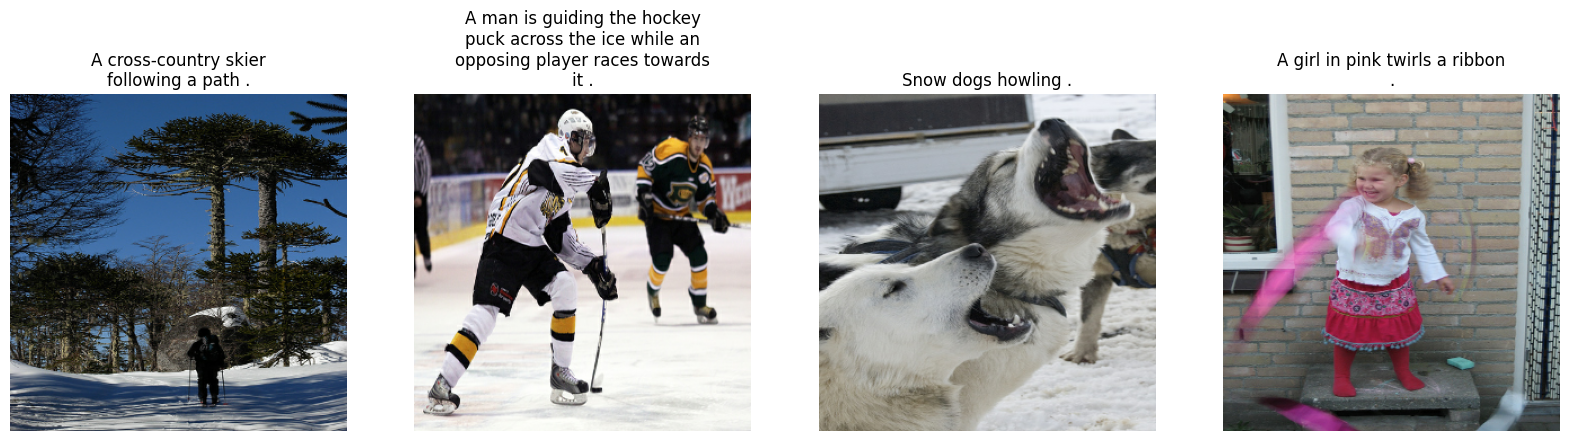

In [13]:
import tensorflow as tf
import matplotlib.pyplot as plt
from textwrap import wrap

# Visualization
f, ax = plt.subplots(1, 4, figsize=(20, 5))
for id, data in enumerate(train_ds.take(4)):
    ax[id].imshow(data["image_tensor"].numpy())
    caption = "\n".join(wrap(data["caption"].numpy().decode("utf-8"), 30))
    ax[id].set_title(caption)
    ax[id].axis("off")

# Text Preprocessing

here, I'm adding tokens to represent the < start > and < end > of each captions.

In [14]:
def add_start_end_tokens(data):
  start = tf.convert_to_tensor("<start>")
  end = tf.convert_to_tensor("<end>")
  data['caption'] = tf.strings.join(
      [start, " ", data['caption'], " ", end]
  )
  return data

train_ds = train_ds.map(add_start_end_tokens)

# Preprocess and Tokenize the captions

In [15]:
MAX_CAP_LENGTH = 60
VOCAB_SIZE = 10000

def standardize(inputs):
    inputs = tf.strings.lower(inputs)
    return tf.strings.regex_replace(
        inputs, r"[!\"#$%&\(\)\*\+.,\-/:;=?@\[\\\]^_`{|}~]", ""
    )

tokenizer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    standardize=standardize,
    output_mode="int",
    output_sequence_length=MAX_CAP_LENGTH,
)

tokenizer.adapt(train_ds.map(lambda x: x["caption"]))

In [16]:
vocab = tokenizer.get_vocabulary()
print(vocab[:10])  # First 10 tokens
print("Index of 'is':", vocab.index('is'))

['', '[UNK]', 'a', '<start>', '<end>', 'in', 'the', 'and', 'on', 'is']
Index of 'is': 9


In [17]:
sample_captions = []
for d in train_ds.take(4):
  sample_captions.append(d['caption'].numpy().decode('utf-8'))

print(sample_captions)

['<start> A boy wearing skates sliding down concrete railing of steps near a pole . <end>', '<start> A little girl wearing a pink shirt spins on a merry-go-round at a park . <end>', '<start> A man in a blue cowboy hat is riding a white horse . <end>', '<start> one white dog is running with a tennis ball in his mouth while another dog jogs along <end>']


# Creating a tf.data for training

In [18]:
def create_ds_fn(data):
    image_tensor = data['image_tensor']
    caption = tokenizer(data['caption'])  # shape: (MAX_CAP_LENGTH,)

    # Add batch dimension for safety
    caption = tf.convert_to_tensor(caption)

    # Roll captions (shift left by 1 token)
    rolled_caption = tf.roll(caption, shift=-1, axis=0)

    # Set last token to 0 (padding)
    rolled_caption = tf.tensor_scatter_nd_update(
        rolled_caption,
        indices=[[MAX_CAP_LENGTH - 1]],
        updates=[0]
    )

    return (image_tensor, caption), rolled_caption

In [19]:
batched_ds = (
    train_ds
    .map(create_ds_fn)
    .batch(batch_size=16)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Designing the Image Captioning model

It consists of an image encoder, followed by a caption decoder

## Image Encoder

Extract features through the feature extractor and pass it into a fully connected layer

In [20]:
FEATURE_EXTRACTOR.trainable = False

image_input = Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), name='image_tensor')
image_features = FEATURE_EXTRACTOR(image_input)

X = Reshape((FEATURES_SHAPE[0] * FEATURES_SHAPE[1], FEATURES_SHAPE[2]))(image_features)
encoder_output = Dense(ATTENTION_DIM, activation='relu')(X)

In [21]:
encoder = tf.keras.Model(inputs=image_input, outputs=encoder_output)
# encoder.summary

# Caption Decoder
Here, this incorporates an attention mechanism that focuses on different parts of the code

In [22]:
ENCODER_FEATURE_SHAPE = (100, ATTENTION_DIM)


word_input = Input(shape=(MAX_CAP_LENGTH,), name="caption")

#Embedding layer
word_embedding = Embedding(
    input_dim=VOCAB_SIZE,
    output_dim=WORD_EMBEDDING_DIM,
    name="word_embedding"
)
embed_x = word_embedding(word_input)


#GRU Layer
decoder_gru = GRU(
    ATTENTION_DIM,
    return_sequences=True,
    return_state=True,
    name="decoder_gru"
)
gru_output, gru_state = decoder_gru(
    embed_x
)

#Bahdanau Style Attention
decoder_attention = Attention(name="bahdanau_attention")
context_vector = decoder_attention([gru_output, encoder_output])

#Skip Connection
addition = Add()([gru_output, context_vector])

#Layer Normalization
layer_norm = LayerNormalization(axis=-1, name="decoder_norm")
layer_norm_out = layer_norm(addition)

#Final Dense layer to generate logits
decoder_dense = Dense(VOCAB_SIZE, activation='softmax', name="decoder_dense")
decoder_output = decoder_dense(layer_norm_out)

#Defining the full decoder model
decoder = tf.keras.Model(inputs=[word_input, encoder_output], outputs=decoder_output, name='decoder')

decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ caption (InputLayer)      │ (None, 60)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ word_embedding            │ (None, 60, 512)        │      5,120,000 │ caption[1][0]          │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_gru (GRU)         │ [(None, 60, 512),      │      1,575,936 │ word_embedding[1][0]   │
│                           │ (None, 512)]           │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ keras_tensor_1560CLONE    │ (None, 64, 512)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bahdanau_attention        │ (None, 60, 512)        │              0 │ decoder_gru[1][0],     │
│ (Attention)               │                        │                │ keras_tensor_1560CLON… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 60, 512)        │              0 │ decoder_gru[1][0],     │
│                           │                        │                │ bahdanau_attention[1]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_norm              │ (None, 60, 512)        │          1,024 │ add[1][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_dense (Dense)     │ (None, 60, 10000)      │      5,130,000 │ decoder_norm[1][0]     │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 11,826,960 (45.12 MB)

 Trainable params: 11,826,960 (45.12 MB)

 Non-trainable params: 0 (0.00 B)

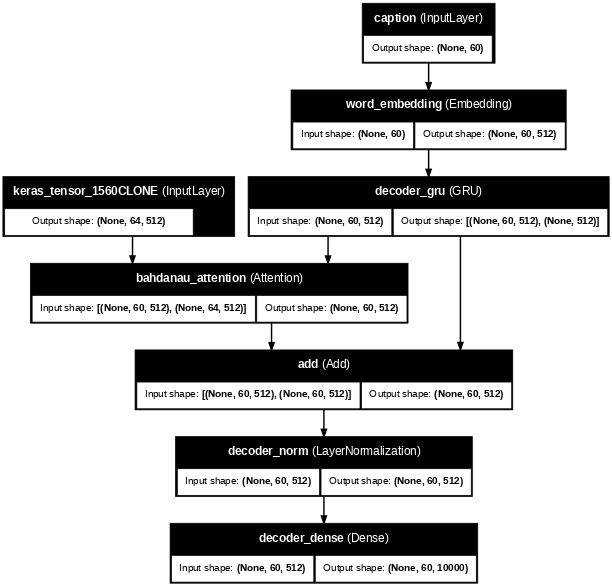

In [23]:
from tensorflow.keras.utils import plot_model

# Save the model plot as a PNG image
plot_model(
    decoder,
    to_file="decoder_model.png",       # Save to file
    show_shapes=True,                  # Show output shapes
    show_layer_names=True,             # Show layer names
    expand_nested=True,                # Expand nested layers if any
    dpi=52                             # Lower dpi = smaller image size
)

# Training the Model

In [24]:
tf.config.run_functions_eagerly(True)

image_captioning_model = tf.keras.Model(inputs=[image_input, word_input], outputs=decoder_output)

## Define the loss function

In [25]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
   from_logits=True, reduction='none'
)

def loss_function(real, pred):
  loss_ = loss_object(real, pred)
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  mask = tf.cast(mask, dtype=tf.int32)
  sentence_len = tf.reduce_sum(mask)
  loss_ = loss_[:sentence_len]

  return tf.reduce_mean(loss_, 1)

In [26]:
image_captioning_model.compile(optimizer='adam', loss=loss_function)

# Training

In [27]:
history = image_captioning_model.fit(
    batched_ds,
    epochs=10,
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


430/430 ━━━━━━━━━━━━━━━━━━━━ 504s 1s/step - loss: 1.4200
Epoch 2/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 494s 1s/step - loss: 0.6763
Epoch 3/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 492s 1s/step - loss: 0.5416
Epoch 4/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 492s 1s/step - loss: 0.4380
Epoch 5/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 492s 1s/step - loss: 0.3507
Epoch 6/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 492s 1s/step - loss: 0.2868
Epoch 7/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 493s 1s/step - loss: 0.2365
Epoch 8/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 491s 1s/step - loss: 0.1952
Epoch 9/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 491s 1s/step - loss: 0.1647
Epoch 10/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 491s 1s/step - loss: 0.1311


# Captioning

In [28]:
from tensorflow.keras.layers import Input, Add, LayerNormalization
from tensorflow.keras.models import Model

# These layers are reused from your training model
# Make sure these are already defined:
# word_embedding, decoder_gru, decoder_attention, layer_norm, decoder_output_dense

# 1. Inputs
word_input = Input(shape=(1,), name="word_input")  # just one word at a time
encoder_output_input = Input(shape=(64, ATTENTION_DIM), name="encoder_output")  # image features
gru_state_input = Input(shape=(ATTENTION_DIM,), name="gru_state_input")  # previous hidden state

# 2. Embedding (reuse the trained embedding layer)
embed_step = word_embedding(word_input)  # shape = (batch, 1, ATTENTION_DIM)

# 3. GRU (reuse the trained GRU layer, pass initial_state)
gru_output, gru_state = decoder_gru(embed_step, initial_state=gru_state_input)  # output shape = (batch, 1, ATTENTION_DIM)

# 4. Attention (reuse trained attention layer)
context_vector = decoder_attention([gru_output, encoder_output_input])  # shape = (batch, 1, ATTENTION_DIM)

# 5. Add GRU output + context vector
addition_output = Add()([gru_output, context_vector])

# 6. Layer Norm
layer_norm_output = layer_norm(addition_output)



# 7. Final Dense layer (reuse trained dense layer)
decoder_output = decoder_dense(layer_norm_output)  # shape = (batch, 1, vocab_size)

# 8. Build the prediction model
decoder_pred_model = Model(
    inputs=[word_input, encoder_output_input, gru_state_input],
    outputs=[decoder_output, gru_state],
    name="decoder_prediction_model"
)

In [29]:
MINIMUM_SENTENCE_LENGTH = 5

# Building the word-to-index map
vocab = tokenizer.get_vocabulary()
word_to_index = lambda word: vocab.index(word)

index_to_word = {i: word for i, word in enumerate(vocab)}

In [30]:
def predict_caption(filename):
    # 1. Loading and preprocessing the image
    img = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
    img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    img_display = img / 255.0

    img = img / 255.0
    img_batch = tf.expand_dims(img, axis=0)  # Shape: (1, H, W, C)

    # 2. Extracting features using the encoder
    features = encoder(img_batch)

    # 3. Initializing decoder state with BATCH DIMENSION
    gru_state = tf.zeros((1, ATTENTION_DIM))

    dec_input = tf.expand_dims([word_to_index("<start>")], 1)
    result = []

    # 4. Generating caption word by word
    for _ in range(MAX_CAP_LENGTH):
        if len(gru_state.shape) == 1:
            gru_state = tf.expand_dims(gru_state, 0)

        predictions, gru_state = decoder_pred_model([dec_input, features, gru_state])

        # Processing predictions
        predictions = tf.squeeze(predictions)

        # Sampling from top k predictions
        top_probs, top_idxs = tf.math.top_k(predictions, k=10)
        sampled_idx = tf.random.categorical(tf.math.log([top_probs]), 1)[0][0].numpy()
        predicted_id = top_idxs[sampled_idx].numpy()

        # Getting the word
        predicted_word = index_to_word[predicted_id]
        result.append(predicted_word)

        # Stop if we predict the end token
        if predicted_word == "<end>":
            break

        # Update input for next iteration
        dec_input = tf.expand_dims([predicted_id], 1)

    # 5. Clean up the result
    if result and result[-1] == "<end>":
        result = result[:-1]

    return img_display, result

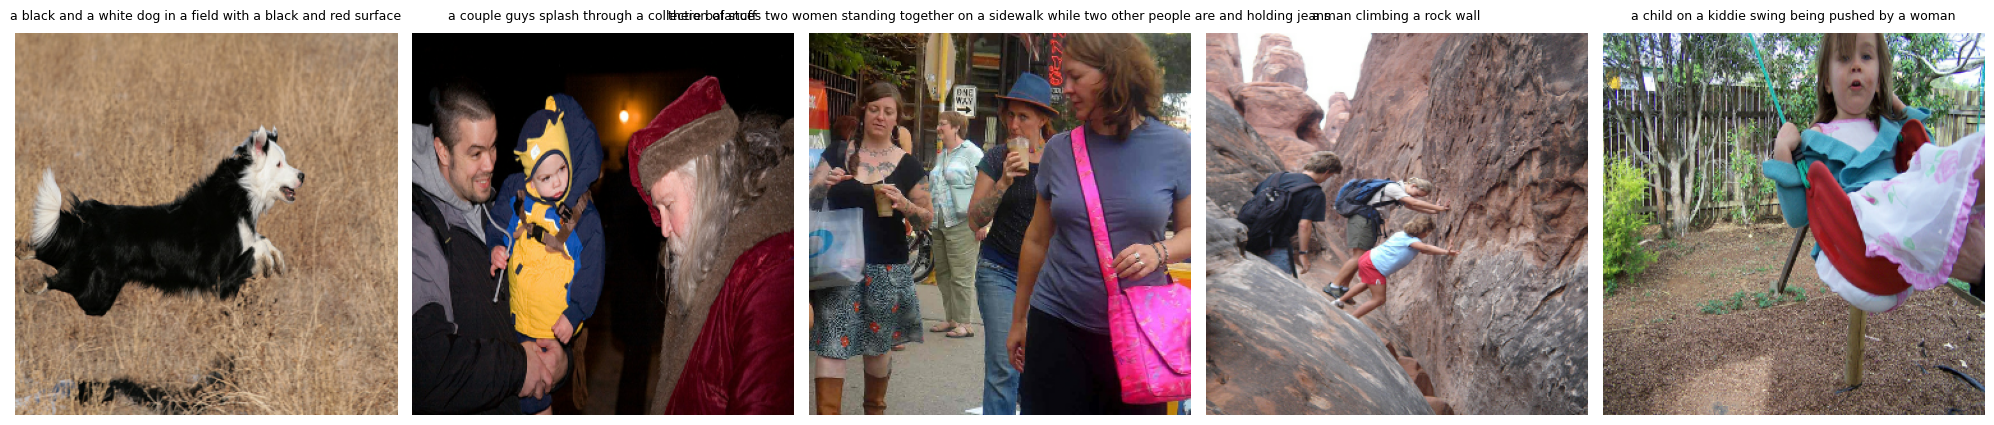

In [31]:
import os
import matplotlib.pyplot as plt

images_dir = os.path.join(dataset_path, "Images")

# Define number of images
num_samples = 5

# Set up subplot grid
fig, axs = plt.subplots(1, num_samples, figsize=(num_samples * 4, 5))

for i in range(num_samples):
    # 1. Get image path and caption
    image_filename = X_test[i]
    ground_truth_caption = y_test[i]

    # 2. Create full path to image
    full_path = os.path.join(images_dir, image_filename)

    # 3. Predict caption
    try:
        generated_img, predicted_caption = predict_caption(full_path)
    except tf.errors.NotFoundError:
        print(f"❌ File not found: {full_path}")
        continue

    # 4. Display image
    ax = axs[i]
    ax.imshow(generated_img.numpy())
    ax.axis("off")

    # 5. Show predicted caption under image
    caption_text = " ".join(predicted_caption)
    ax.set_title(caption_text, fontsize=9, pad=10, wrap=True)

# Adjust layout
plt.tight_layout()
plt.show()

In [32]:
import os
import csv

def generate_caption_csv(X_val, y_val, dataset_path, output_csv="caption_predictions.csv"):
    images_dir = os.path.join(dataset_path, "Images")
    results = []

    for i in range(len(X_val)):
        image_filename = X_val[i]
        ground_truth_caption = y_val[i]
        full_path = os.path.join(images_dir, image_filename)

        try:
            _, predicted_caption = predict_caption(full_path)
        except Exception as e:
            print(f"❌ Skipping {image_filename}: {e}")
            continue

        caption_text = " ".join(predicted_caption)
        results.append({
            "image_filename": image_filename,
            "ground_truth_caption": ground_truth_caption,
            "predicted_caption": caption_text
        })

    # Save to CSV
    with open(output_csv, "w", newline="", encoding="utf-8") as f:
        writer = csv.DictWriter(f, fieldnames=["image_filename", "ground_truth_caption", "predicted_caption"])
        writer.writeheader()
        writer.writerows(results)

    print(f"✅ CSV saved as '{output_csv}' with {len(results)} rows.")

In [33]:
generate_caption_csv(X_test, y_test, dataset_path)

✅ CSV saved as 'caption_predictions.csv' with 1214 rows.


In [34]:
df = pd.read_csv("/kaggle/working/caption_predictions.csv")
df.head()

,image_filename,ground_truth_caption,predicted_caption
0,/kaggle/working/datasets/adityajn105/flickr8k/...,"A black-and-white dog bounds off the ground , ...",a black and white dog bounds a through a field...
1,/kaggle/working/datasets/adityajn105/flickr8k/...,A child staring at Santa .,three people are looking at the camera
2,/kaggle/working/datasets/adityajn105/flickr8k/...,Three woman walk down a city street and one ha...,the two girls are walking together holding han...
3,/kaggle/working/datasets/adityajn105/flickr8k/...,"The two people are standing on a rock , holdin...",a man in a blue cap red and white rock climbing
4,/kaggle/working/datasets/adityajn105/flickr8k/...,A closeup of a little girl on a swing .,a little girl with a pink dress runs down a sa...
